400
焊接位置/mm： 13 9
[179.31034482758622, 275.8620689655172]
圆半径 12.895577931397362 mm
Circle center (cx_scaled/mm, cy_scaled/mm): (13.35 ± 0.03, -1.27 ± 0.22)
Circle radius (r_scaled/mm): 12.90 ± 0.21


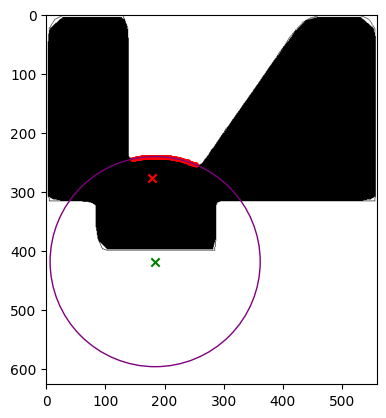

In [4]:
# 拟合并且保存图片
import csv
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from matplotlib.patches import Circle
import os
# from scipy.optimize import curve_fit

def circle(x, cx, cy, r):
    return np.sqrt(r**2 - (x - cx)**2) + cy


# 创建一个列表，用于存储圆心和半径
circle_data = []
# 读取黑白图片
filename = 'cropped_p1-1_0036.bmp'
folder_path = './cropped/cropped_p1-1/'
# os.path.join(output_path, 'fitted_'+filename)
image = cv2.imread(os.path.join(folder_path, filename), cv2.IMREAD_GRAYSCALE)
# image = cv2.imread('./cropped/cropped_p2-1_0015.bmp', cv2.IMREAD_GRAYSCALE)
width, length = image.shape
print(width)

# 定义特定区域的边界框 [start_row:end_row, start_col:end_col]

start_row, end_row = 200, 280  # 请根据实际情况调整
start_col, end_col = 145, 255

# 裁剪图像
cropped_image = image[start_row:end_row, start_col:end_col]

# 获取裁剪后图像的形状
rows, cols = cropped_image.shape

# 存储每列的第一个黑色点的坐标
first_black_pixels = []

# 遍历每一列
for col in range(cols):
    # 找到当前列中第一个黑色点的行坐标
    black_pixel_row = np.argmax(cropped_image[:, col] == 0)
    
    # 如果找到了黑色点，则记录坐标
    if black_pixel_row > 0:  # 0 表示未找到黑色点
        # 转换坐标为完整图像坐标
        full_image_row =width - (start_row + black_pixel_row)
        first_black_pixels.append((start_col + col, full_image_row))

# 将坐标转换为 NumPy 数组
first_black_pixels = np.array(first_black_pixels)
# print(first_black_pixels)

# 进行圆形拟合
# p0 = [np.mean(first_black_pixels[:, 0]), np.mean(first_black_pixels[:, 1]), 10.0]  # 初始猜测值
p0 = [200, 350, 150.0]  # 初始猜测值
params, covariance = curve_fit(circle, first_black_pixels[:, 0], first_black_pixels[:, 1], p0=p0)

# 提取拟合结果
cx, cy, r = params

# 生成拟合曲线的 x 值范围
fit_x = np.linspace(min(first_black_pixels[:, 0]), max(first_black_pixels[:, 0]), 100)

# 计算拟合曲线的 y 值
fit_y = circle(fit_x, cx, cy, r)

# 显示图像
output_path = './fitted/fitted_p1-1/'

output_filename = os.path.join(output_path, 'fitted_'+filename.replace('bmp','jpg'))

plt.imshow(image, cmap='gray')

# 在坐标轴上画出每列的第一个黑色点的位置
plt.scatter(first_black_pixels[:, 0], width-first_black_pixels[:, 1], color='red', s=5)
# 画出拟合圆
# plt.plot(fit_x, fit_y, color='blue')
circle_patch = Circle((cx, width-cy), r, color='purple', fill=False)
plt.gca().add_patch(circle_patch)


scale_factor = 29 / width  # 将369像素映射到29mm

# 标记圆心位置
plt.scatter(cx, width-cy, color='green', marker='x')

p1= [0, 3]
p1_scaled=[0,0]
p1_scaled[0] = (p1[0]+13)/scale_factor
p1_scaled[1] = width - (p1[1]+6)/scale_factor 
print( "焊接位置/mm：", p1[0]+13, p1[1]+6) 

print(p1_scaled)
plt.scatter(p1_scaled[0], p1_scaled[1], color='red', marker='x')

# # 显示图像、黑色像素位置和拟合圆
# plt.axis('equal')
# plt.show()
plt.savefig(output_filename)
print("圆半径",r*scale_factor,"mm")


scaled_first_black_pixels = first_black_pixels * scale_factor
# p0_scaled = [175 * scale_factor, 60 * scale_factor, 150.0 * scale_factor]  # 初始猜测值
p0_scaled = [p * scale_factor for p in p0]
params_scaled, covariance_scaled = curve_fit(circle, scaled_first_black_pixels[:, 0], scaled_first_black_pixels[:, 1], p0=p0_scaled)
# 计算标准偏差作为拟合误差的估计
fit_errors = np.sqrt(np.diag(covariance_scaled))
print(f"Circle center (cx_scaled/mm, cy_scaled/mm): ({cx*scale_factor:.2f} ± {fit_errors[0]:.2f}, {cy*scale_factor:.2f} ± {fit_errors[1]:.2f})")
print(f"Circle radius (r_scaled/mm): {r*scale_factor:.2f} ± {fit_errors[2]:.2f}")
circle_data.append((round(cx*scale_factor, 1), round(cy*scale_factor, 1), round(r*scale_factor, 1)))

with open('predict.txt', 'r') as f:
    reader = csv.reader(f)
    data = list(reader)

# 添加新的数据
# for i in range(len(data)):
#     # 如果原有的列数不足6列，用空字符串填充
#     while len(data[i]) < 6:
#         data[i].append('')
    # 添加新的数据
    
# 找到第一个第四、五、六列为空的行的索引
start_index = next((i for i, row in enumerate(data) if all(x == '' for x in row[3:6])), len(data))

# 添加新的数据
for i in range(start_index, start_index + len(circle_data)):
    if i < len(data):
        data[i][3:6] = circle_data[i - start_index]
    else:
        data.append(circle_data[i - start_index] + [''] * (len(data[0]) - 6))

# 写回文件
with open('predict.txt', 'w', newline='') as f:
    writer = csv.writer(f)
    writer.writerows(data)
# cv2.imwrite(output_filename, image)

395


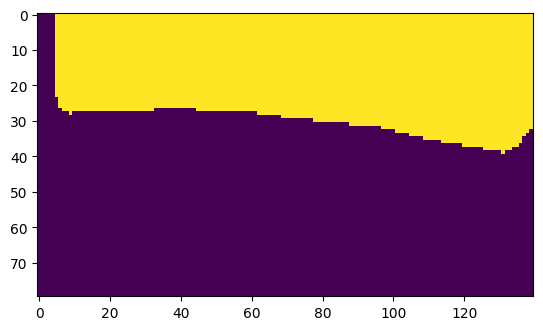

In [7]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from matplotlib.patches import Circle
# from scipy.optimize import curve_fit

def circle(x, cx, cy, r):
    return np.sqrt(r**2 - (x - cx)**2) + cy

# 读取黑白图片
image = cv2.imread('./cropped/cropped_p1-1_0002.bmp', cv2.IMREAD_GRAYSCALE)
plt.imshow(image)
width, length = image.shape
print(width)

# 定义特定区域的边界框 [start_row:end_row, start_col:end_col]

start_row, end_row = 200, 280  # 请根据实际情况调整
start_col, end_col = 135, 275
# imgcrop = image.crop((start_row, start_col, end_row, end_col))
# plt.imshow(imgcrop)

# 裁剪图像
cropped_image = image[start_row:end_row, start_col:end_col]
plt.imshow(cropped_image)